In [ ]:
!pip install -U ultralytics onnx

In [ ]:
from ultralytics import YOLO
print(YOLO.version)


AttributeError: type object 'YOLO' has no attribute 'version'

In [ ]:
from google.colab import files
uploaded = files.upload()  # choose your model.pt

import torch
import torch.nn as nn


Saving model_- 12 march 2025 15_26.pt to model_- 12 march 2025 15_26 (1).pt


In [21]:
from ultralytics import YOLO

model_path = list(uploaded.keys())[0]
model = YOLO(model_path)

# Step 4: Export to ONNX
onnx_file =model.export(format="onnx")

print(f"Model converted and saved at: {onnx_file}")

# Step 5: Download ONNX file
files.download(onnx_file)


Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'model_- 12 march 2025 15_26 (1).pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)

ONNX: starting export with onnx 1.19.0 opset 22...
ONNX: slimming with onnxslim 0.1.70...
ONNX: export success ✅ 1.6s, saved as 'model_- 12 march 2025 15_26 (1).onnx' (10.1 MB)

Export complete (2.2s)
Results saved to /content
Predict:         yolo predict task=detect model=model_- 12 march 2025 15_26 (1).onnx imgsz=640  
Validate:        yolo val task=detect model=model_- 12 march 2025 15_26 (1).onnx imgsz=640 data=/content/datasets/human_detection/dataset.yaml  
Visualize:       https://netron.app
Model converted and saved at: model_- 12 march 2025 15_26 (1).onnx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import onnx
model = onnx.load(onnx_file)
print(onnx.helper.printable_graph(model.graph))


graph main_graph (
  %images[FLOAT, 1x3x640x640]
) initializers (
  %model.0.conv.weight[FLOAT, 16x3x3x3]
  %model.0.conv.bias[FLOAT, 16]
  %model.1.conv.weight[FLOAT, 32x16x3x3]
  %model.1.conv.bias[FLOAT, 32]
  %model.2.cv1.conv.weight[FLOAT, 32x32x1x1]
  %model.2.cv1.conv.bias[FLOAT, 32]
  %onnx::Split_185[INT64, 2]
  %model.2.m.0.cv1.conv.weight[FLOAT, 8x16x3x3]
  %model.2.m.0.cv1.conv.bias[FLOAT, 8]
  %model.2.m.0.cv2.conv.weight[FLOAT, 16x8x3x3]
  %model.2.m.0.cv2.conv.bias[FLOAT, 16]
  %model.2.cv2.conv.weight[FLOAT, 64x48x1x1]
  %model.2.cv2.conv.bias[FLOAT, 64]
  %model.3.conv.weight[FLOAT, 64x64x3x3]
  %model.3.conv.bias[FLOAT, 64]
  %model.4.cv1.conv.weight[FLOAT, 64x64x1x1]
  %model.4.cv1.conv.bias[FLOAT, 64]
  %onnx::Split_205[INT64, 2]
  %model.4.m.0.cv1.conv.weight[FLOAT, 16x32x3x3]
  %model.4.m.0.cv1.conv.bias[FLOAT, 16]
  %model.4.m.0.cv2.conv.weight[FLOAT, 32x16x3x3]
  %model.4.m.0.cv2.conv.bias[FLOAT, 32]
  %model.4.cv2.conv.weight[FLOAT, 128x96x1x1]
  %model.4.cv2.c

Model loaded successfully.
Input Name: images
Output Name: output0


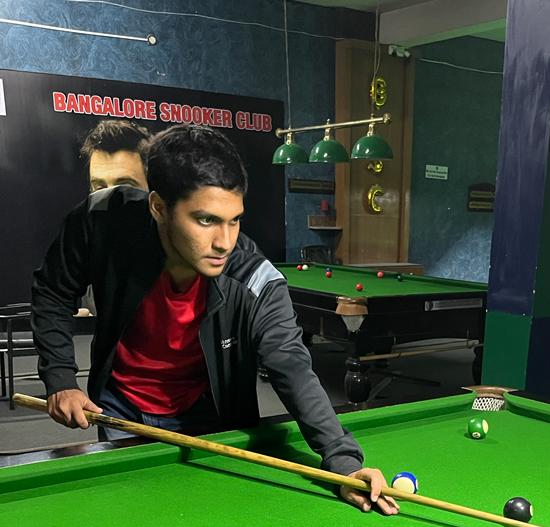

Inference Output: [array([[[     9.4325,      21.438,      35.029, ...,      525.28,      559.18,      602.26],
        [     13.548,      12.241,      12.944, ...,      540.46,      506.37,      492.54],
        [     18.687,      42.595,      71.203, ...,      229.83,      162.38,      75.386],
        [     27.886,      24.677,      25.999, ...,      198.65,      267.15,      293.94],
        [ 6.9439e-06,  4.2617e-06,  1.3411e-06, ...,  0.00011978,   9.647e-05,  0.00027239]]], dtype=float32)]


In [34]:
import cv2
import numpy as np
import onnxruntime as ort
from google.colab.patches import cv2_imshow

# Load ONNX model
onnx_model_path = onnx_file  # Change to your ONNX model file
session = ort.InferenceSession(onnx_model_path)

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
print("Model loaded successfully.")
print("Input Name:", input_name)
print("Output Name:", output_name)

# Load image
img_path = "/content/rand.png"  # Change to your image file
img = cv2.imread(img_path)
cv2_imshow(img)

# Preprocess image
def preprocess(img, input_shape=(640,640)):
    img_resized = cv2.resize(img, input_shape)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_norm = img_rgb.astype(np.float32) / 255.0
    img_transposed = np.transpose(img_norm, (2,0,1))  # Channels-first
    img_batch = np.expand_dims(img_transposed, axis=0)  # Add batch dimension
    return img_batch

input_tensor = preprocess(img, input_shape=(640,640))

# Run inference
outputs = session.run([output_name], {input_name: input_tensor})

print("Inference Output:", outputs)


In [50]:
def decode_output(output_tensor, conf_threshold=0.5, forced_class=6):
    tensor = output_tensor[0]  # shape = (5, 8400)
    tensor = tensor.T  # shape = (8400, 5)

    boxes = []
    for det in tensor:
        x_c, y_c, w, h, conf = det
        if conf > conf_threshold:
            x1 = int(x_c - w / 2)
            y1 = int(y_c - h / 2)
            x2 = int(x_c + w / 2)
            y2 = int(y_c + h / 2)
            boxes.append([x1, y1, x2, y2, conf, forced_class])
    return boxes
def draw_bboxes(img, boxes):
    for x1, y1, x2, y2, score, class_id in boxes:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f"Class:{class_id} {score:.2f}",
                    (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    return img



In [43]:
boxes = decode_output(outputs, conf_threshold=0.5, forced_class=6)



In [51]:
boxes

[[35, 149, 440, 564, array([    0.87285], dtype=float32), 6],
 [34, 150, 437, 572, array([    0.83805], dtype=float32), 6],
 [34, 148, 437, 559, array([    0.85326], dtype=float32), 6],
 [35, 150, 447, 573, array([    0.91637], dtype=float32), 6],
 [36, 150, 446, 577, array([    0.89066], dtype=float32), 6],
 [35, 149, 439, 570, array([    0.88376], dtype=float32), 6],
 [36, 150, 451, 576, array([     0.9005], dtype=float32), 6],
 [34, 151, 452, 578, array([     0.8616], dtype=float32), 6],
 [36, 148, 438, 571, array([    0.86943], dtype=float32), 6],
 [38, 150, 457, 575, array([    0.88875], dtype=float32), 6]]

In [55]:
import cv2

def nms_boxes(boxes, conf_threshold=0.5, iou_threshold=0.4):
    final_boxes = []

    coords = []
    confidences = []
    class_ids = []

    for box in boxes:
        x1, y1, x2, y2, conf_array, class_id = box
        conf = float(conf_array)  # unwrap confidence
        if conf > conf_threshold:
            coords.append([x1, y1, x2 - x1, y2 - y1])  # x, y, width, height
            confidences.append(conf)
            class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(coords, confidences, conf_threshold, iou_threshold)

    if len(indices) > 0:
        for i in indices.flatten():
            final_boxes.append([coords[i][0], coords[i][1],
                                coords[i][0] + coords[i][2],
                                coords[i][1] + coords[i][3],
                                confidences[i],
                                class_ids[i]])
    return final_boxes


In [58]:
filtered_boxes = nms_boxes(boxes, conf_threshold=0.5, iou_threshold=0.4)
filtered_boxes

[[35, 150, 447, 573, 0.9163694381713867, 6]]

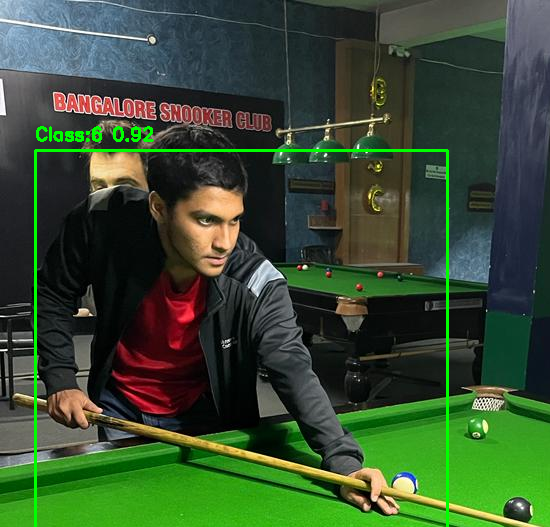

In [61]:
img_with_boxes = draw_bboxes(img.copy(), filtered_boxes)
cv2_imshow(img_with_boxes)